<a href="https://colab.research.google.com/github/andythomasc/Text-Style-Transfer/blob/main/encoder-only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instance check

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Aug 27 22:34:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import pandas as pd
from pandas import DataFrame
import numpy as np

import pandas as pd
from torch.utils.data import Dataset, DataLoader
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import os


import time
import torchtext

from torchtext.legacy import data
import torch

#from utils import tensor2text
import torch.nn.functional as F

import math

from torch import nn, optim
#from tensorboardX import SummaryWriter
from torch.nn.utils import clip_grad_norm_

#from evaluator import Evaluator
#from utils import tensor2text, calc_ppl, idx2onehot, add_noise, word_drop


In [4]:

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset


#Pytorch Transformer

In [5]:

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

#PositionalEncoding
 module injects some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension as the embeddings so that the two can be summed. Here, we use sine and cosine functions of different frequencies.

In [6]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

#Loading Data and stuff

In [7]:
text_layperson = open('/content/drive/My Drive/Colab Notebooks/style_transfer/training_files/label_1_parallel.txt').read().splitlines()
text_expert = open('/content/drive/My Drive/Colab Notebooks/style_transfer/training_files/label_0_parallel.txt').read().splitlines()


concatenated = []

for i in range(len(text_layperson)):
  concatenated.append(text_layperson[i])
  concatenated.append(text_expert[i])

together = []

for i in range(len(text_layperson)):
  together.append((text_layperson[i],text_expert[i]))

#Vocab

In [8]:
import spacy  # for tokenizer


spacy_eng = spacy.load("en")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]
vocab = Vocabulary(1)
vocab.build_vocabulary(concatenated)

In [9]:
## the custom dataset is better off having the things as a tuple or some shit, rather than what this abomination is.


In [10]:
#numericalized_caption = [self.vocab.stoi["<SOS>"]]
#numericalized_caption += self.vocab.numericalize(caption)
#numericalized_caption.append(self.vocab.stoi["<EOS>"])

#Custom DAtaset

In [11]:
pad_idx = vocab.stoi["<PAD>"]

In [12]:
class CustomTextDataset(Dataset):
  def __init__(self,expert,layperson,whole):
    #parse arguments such as the list of tokens
    self.expert = expert
    self.layperson = layperson
    self.whole=whole
    
    #create vocab and build ??

  def __len__(self):
    return len(self.whole)


  def __getitem__(self, idx):
    exp = self.expert[idx]
    lay = self.layperson[idx]

    numericalized_exp = [vocab.stoi["<SOS>"]]
    numericalized_exp +=vocab.numericalize(exp)
    numericalized_exp.append(vocab.stoi["<EOS>"])

    numericalized_lay = [vocab.stoi["<SOS>"]]
    numericalized_lay +=vocab.numericalize(lay)
    numericalized_lay.append(vocab.stoi["<EOS>"])

    return torch.tensor(numericalized_lay),torch.tensor(numericalized_exp)

  #  return self.whole[idx]


In [13]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        lay = [item[0] for item in batch]
        lay = pad_sequence(lay, batch_first=False, padding_value=self.pad_idx)
        exp = [item[1] for item in batch]
        exp = pad_sequence(exp, batch_first=False, padding_value=self.pad_idx)

        return lay, exp

In [14]:
dataset = CustomTextDataset(text_expert,text_layperson,together)

In [15]:
val_dataset = CustomTextDataset(text_expert,text_layperson,together)

In [16]:
from torch.nn.utils.rnn import pad_sequence  # pad batch


#Data Loader

In [17]:
dataloader = DataLoader(dataset,batch_size=1,shuffle=True, collate_fn=MyCollate(pad_idx=pad_idx))


In [18]:
val_loader = DataLoader(val_dataset,batch_size=1,shuffle=True, collate_fn=MyCollate(pad_idx=pad_idx))

In [ ]:
def get_batch(dataloader):
  for i, batch in enumerate(dataloader):
    expert_batch = batch[0]
    layperson_batch = batch[1]
   # print(batch[0])
    #print(batch[1])
    break



  return expert_batch,layperson_batch

#Maybe Train?!?!

In [19]:
def batch_preprocess(batch_0,batch_1,pad_idx):
  diff = batch_1.size(0) - batch_0.size(0) # filling them with pads if they're distinct in size

  if diff < 0: 
    pad = torch.full_like(batch_0[:-diff:, :batch_0.size(1)], pad_idx)
    batch_1 = torch.cat((batch_1, pad), 0)

  elif diff > 0:
    pad = torch.full_like(batch_1[:diff, :batch_1.size(1)], pad_idx)
    batch_0 = torch.cat((batch_0, pad), 0)

  #pos_styles = torch.ones_like(batch_pos[:, 0])
  #neg_styles = torch.zeros_like(batch_neg[:, 0])

 # print('batch size of batch_0 is: ', batch_0.shape)
 # print('batch size of batch_1 is: ', batch_1.shape)
  return batch_0,batch_1


In [20]:
ntokens = len(vocab)  # size of vocabulary
emsize = 1024  # embedding dimension
d_hid = 2048  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 12  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [21]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 3e-5  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module, dataloader) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    #src_mask = generate_square_subsequent_mask(bptt).to(device)

    #for each batch
    for i, batch in enumerate(dataloader):
      source, targets = batch_preprocess(batch[0].to(device),batch[1].to(device),0)
      #source = batch[0]
      #targets = batch[1]

      src_mask = generate_square_subsequent_mask(source.size(0)).to(device)
      output = model(source, src_mask)
      output = output.permute(0,2,1)
     # targets = targets.unsqueeze(-1)
      #targets = targets.permute(1,0)
      loss = criterion(output.to(device), targets.to(device))


      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()

      total_loss += loss.item()

      if i % log_interval == 0 and i > 0:
          lr = scheduler.get_last_lr()[0]
          ms_per_batch = (time.time() - start_time) * 1000 / log_interval
          cur_loss = total_loss / log_interval
          ppl = math.exp(cur_loss)
         # print(f'| epoch {epoch:3d} | {i:5d}/{num_batches:5d} batches | '
                #f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
              #  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
          total_loss = 0
          start_time = time.time()


In [22]:

def evaluate(model: nn.Module, loader) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    #src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
      for i, batch in enumerate(loader):
        source, targets = batch_preprocess(batch[0].to(device),batch[1].to(device),0)
        #targets = targets.unsqueeze(-1)
        #source = batch[0]
        #targets = batch[1]

        src_mask = generate_square_subsequent_mask(source.size(0)).to(device)
        batch_size = batch[0].size(0)
        output = model(source, src_mask)
        output = output.permute(0,2,1)
        #output_flat = output.view(-1, ntokens)
        total_loss +=  criterion(output, targets).item()
        
        
    return total_loss / (1000 - 1)

In [ ]:
try:
    ans = math.exp(200000)
except OverflowError:
    ans = float('inf')

In [24]:
best_val_loss = float('inf')
epochs = 1
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model,dataloader)
    val_loss = evaluate(model, val_loader)
    try:
      ans = math.exp(val_loss)
    except OverflowError:
      ans = float('inf')
    val_ppl = ans
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 23.09s | valid loss  6.34 | valid ppl   567.04
-----------------------------------------------------------------------------------------


In [25]:

torch.save(model.state_dict(),'/content/drive/My Drive/Colab Notebooks/style_transfer/training_files//save/model_encoder.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/style_transfer/training_files/save/model_encoder.pth'))

RuntimeError: ignored

#plots

In [26]:
history = []

In [30]:
 with torch.no_grad():
      for i, batch in enumerate(val_loader):
        source, targets = batch_preprocess(batch[0].to(device),batch[1].to(device),0)
        #targets = targets.unsqueeze(-1)
        #source = batch[0]
        #targets = batch[1]

        src_mask = generate_square_subsequent_mask(source.size(0)).to(device)
        batch_size = batch[0].size(0)
        output = model(source, src_mask)
        output = output.permute(0,2,1)
        #output_flat = output.view(-1, ntokens)
        loss =  criterion(output, targets).item()
      #  loss = loss.sum() / batch[0].size(0)
       # loss *= 0.25
        history.append(loss)


In [37]:
ppl_history = [math.exp(element) for element in history]

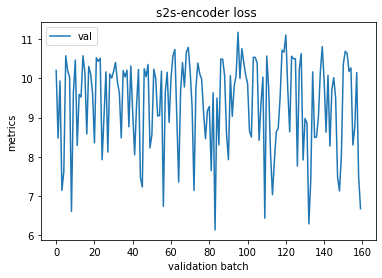

In [40]:
import keras
from matplotlib import pyplot as plt
plt.plot(history)
plt.title('s2s-encoder loss ')
plt.ylabel('metrics')
plt.xlabel('validation batch')
plt.legend(['val'], loc='upper left')
plt.show()


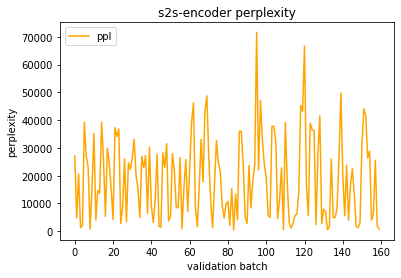

In [44]:
import keras
from matplotlib import pyplot as plt
plt.plot(ppl_history,'orange')
plt.title('s2s-encoder perplexity')
plt.ylabel('perplexity')
plt.xlabel('validation batch')
plt.legend(['ppl'], loc='upper left')
plt.show()


In [45]:
import statistics
statistics.mean(history)


9.368683442473412

In [46]:
statistics.mean(ppl_history)

18863.446512960567

In [ ]:
##eval


model.eval()  # turn on evaluation mode
#total_loss = 0.
results=[]
#src_mask = generate_square_subsequent_mask(bptt).to(device)
with torch.no_grad():
  for i, batch in enumerate(dataloader):
    source, targets = batch_preprocess(batch[0].to(device),batch[1].to(device),0)
    #targets = targets.unsqueeze(-1)
    #source = batch[0]
    #targets = batch[1]

    src_mask = generate_square_subsequent_mask(source.size(0)).to(device)
    batch_size = batch[0].size(0)
    output = model(source, src_mask)
    #output = output.permute(0,2,1)
    
    results.append((targets,output))
    #output_flat = output.view(-1, ntokens)
    #total_loss += batch_size * criterion(output, targets).item()
    
    
#return total_loss / (batch_size - 1)

#LOOKUP and save

In [ ]:
def tensor2text(vocab, tensor):
    tensor = tensor.cpu().numpy()
    text = []
    index2word = vocab.itos
    eos_idx = vocab.stoi['<EOS>']
    unk_idx = vocab.stoi['<UNK>']
   # stop_idxs = [vocab.stoi['!'], vocab.stoi['.'], vocab.stoi['?']]
    for sample in tensor:
      sample_filtered = []
      prev_token = None
      for idx in list(sample):
        if idx == unk_idx or idx == prev_token or idx == eos_idx:
          continue
        prev_token = idx
        sample_filtered.append(index2word[idx])
          
      sample = ' '.join(sample_filtered)
      text.append(sample)

    return text

In [ ]:
gold_res=[]
style_res=[]
for i in range(len(results)):
  gold_res.append(tensor2text(vocab,results[i][0]))
  style_res.append(tensor2text(vocab,results[i][1].argmax(-1)))

In [ ]:
gold_res[1]

['<SOS>',
 'angina',
 'pectoris',
 'or',
 'mi',
 'may',
 'result',
 'from',
 'narrowing',
 'of',
 'the',
 'coronary',
 'artery',
 'orifice',
 'due',
 'to',
 'aortitis',
 'or',
 'coronary',
 'arteritis',
 '.',
 '']

In [ ]:
style_res[0]

['organs',
 'rotten',
 'organs',
 'respiratory',
 'respiratory',
 'rotten',
 'rotten',
 'worms',
 'rotten',
 'worms',
 'worms',
 'swallow',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'worms',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'prescription',
 'rotten',
 'rotten',
 'worms',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'worms',
 'rotten',
 'rotten',
 'hypophysectomy',
 'hypophysectomy',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten',
 'rotten']

#Save tensors into files rather than reading them like a monkey.

In [ ]:
tgts0 = results[0][0]

In [ ]:
tgts0.shape

torch.Size([134, 100])

In [ ]:
for i in range(134):
  print(vocab.itos[tgts0[i]])

KeyError: ignored

In [ ]:
for item in results[0][0][1]:
  print(vocab.itos[item.item()])

death
menses
in
chronic
myoclonus
the
patients
a
an
most
a
fathers
subcutaneous
onset
identified
symptoms
cholestyramine
continuous
however
for
history
group
ankles
cystic
deficits
however
subacromial
basic
at
intractable
the
clinicians
incubation
noninfectious
for
pneumonitis
some
bmi
most
underwater
iv
alternatively
when
cough
conjunctival
regional
thus
recurrence
subsequently
pancreatic
sternum
unexpected
osteomyelitis
hoarding
clinicians
frequency
unlike
tonsillopharyngitis
rash
the
some
they
ct
rarely
pain
about
the
treatment
central
advanced
cholesteatomas
however
concomitant
fungi
prodromal
monthly
early
reduced
treatment
diagnosis
vasculitic
concomitant
however
women
surfactant
olfactory
pruritus
a
fever
children
onset
treatment
in
very
brain
jaundice
nasal
night
small
nasal


In [ ]:
output_list = [results[i][1] for i in range(len(results))]

In [ ]:
len(output_list)

7

In [ ]:
vocab.itos[]

'symptoms'

In [ ]:
out0 = output_list[0] ## first batch

In [ ]:
arm = out0.argmax(-1)


In [ ]:
arm.shape

torch.Size([134, 100])

In [ ]:
arm

tensor([[1486, 1486, 1486,  ..., 1486, 1486, 1486],
        [1486, 3957, 1486,  ..., 1486, 2703, 2925],
        [ 979, 3988, 1486,  ..., 2177, 2654, 3495],
        ...,
        [4546, 4546, 4546,  ..., 4546, 4546, 4546],
        [4546, 3889, 3889,  ..., 3889, 4546, 3889],
        [3889, 3889, 3889,  ..., 3889, 3889, 3889]], device='cuda:0')

In [ ]:
arm[1][0]


tensor(3968, device='cuda:0')

In [ ]:
sentence_from_argmax = [arm[i][7].item() for i in range(134) ]


In [ ]:
for i in range(len(sentence_from_argmax)):
  print(vocab.itos[sentence_from_argmax[i]])

bleed
aspirator
oxygen
sclerosis
orchitis
lose
release
accumulates
hepatic
d
cytomegalovirus
monitors
urethritis
urethritis
monitors
determine
monitors
exaggeration
ceftriaxone
seeing
arytenoids
monitors
interacting
29
urethritis
3rd-
estimated
cytomegalovirus
variant
itch
exaggeration
strong
seeing
estimated
tire
margin
bacteremic
moved
chilblain
arise
bad
peaks
monitors
itch
monitors
breakbone
world
urethritis
jaw
hypoxia
hypoxia
hypoxia
hypoxia
video
video
video
video
3rd-
3rd-
video
video
video
video
video
video
hypoxia
hypoxia
hypoxia
ataxias
ataxias
weakens
weakens
weakens
weakens
choreoathetosis
choreoathetosis
choreoathetosis
choreoathetosis
hypoxia
weakens
weakens
weakens
weakens
weakens
doubt
weakens
weakens
weakens
weakens
weakens
weakens
weakens
weakens
ataxias
ataxias
ataxias
ataxias
ataxias
ataxias
ataxias
weakens
weakens
weakens
weakens
weakens
weakens
cad
cad
cad
ataxias
ataxias
ataxias
ataxias
ataxias
ataxias
ataxias
ataxias
cad
cad
cad
cad
cad
cad
ataxias
ataxias
mall

In [ ]:
out0[0].shape   ## first output?

torch.Size([100, 1916])

In [ ]:
out0.shape

torch.Size([134, 100, 1916])

In [ ]:
results[0][1][].argmax()

tensor(49816, device='cuda:0')

In [ ]:
argmaxes

for i in results[i][1]:
  


In [ ]:
asd = []

In [ ]:
for t in results[0][1]:
  asd.append(t.argmax())

In [ ]:
asd[0].numpy()

array(1)

In [ ]:
for i in asd:
  print(vocab.itos[i.item()])

<SOS>
<UNK>
<UNK>
<UNK>
<UNK>
<UNK>
<UNK>
<UNK>
<UNK>
<UNK>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>


In [ ]:
for i in results[0][1][0]:
  print()

1916

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [ ]:
results[0][1].shape

torch.Size([19, 1916, 1])

In [ ]:
arg_m = results[0][1][0].argmax(-1)

In [ ]:
for i in arg_m:
  print(vocab.itos[arg_m[i]])

KeyError: ignored

In [ ]:
results[0][1][0].shape

torch.Size([1916, 1])

In [ ]:
for te in results[0][1][0]:
  print(te.argmax())

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
